# Capstone Project - Text Summarization

# Exploratory Data Analysis (EDA)
## Contents

1. Data loading
2. Counting of characters, words and sentences
3. Analysis of outliers and exceptions
4. Search and cleaning of bogus articles and words
5. Distribution of characters, words and sentences
6. Tokenization
7. Part-of-Speech (POS)
8. Look for anomalies in the corpus (TO DO)

## 1. Data loading

In [162]:
from os import listdir
import pandas as pd
import time
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.tokenize import word_tokenize, sent_tokenize, RegexpTokenizer
from nltk import pos_tag
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string

In [149]:
# paths to main files
ROOT_DIRECTORY ='../data/'
STORIES_PROCESSED_DIRECTORY = 'processed/stories/'
SUMMARIES_PROCESSED_DIRECTORY = '/processed/summaries/'
LOAD_DIRECTORY_ARTICLES = ROOT_DIRECTORY + STORIES_PROCESSED_DIRECTORY
LOAD_DIRECTORY_SUMMARIES = ROOT_DIRECTORY + SUMMARIES_PROCESSED_DIRECTORY
DATA_CLEANED_DIRECTORY = ROOT_DIRECTORY + 'cleaned/'

In [5]:
def read_txt_file(filename):
    file = open(filename, encoding='utf-8')
    text = file.read()
    file.close()
    return text

In [6]:
lst_articles = listdir(LOAD_DIRECTORY_ARTICLES)
lst_summaries = listdir(LOAD_DIRECTORY_SUMMARIES)

In [156]:
t0 = time.time()
corpus = pd.DataFrame( columns = ['article','summary'])
i = 1
for article_file in lst_articles:
    str_count = str(i)  
    print('Number of read articles: {}'.format(str_count), end='\r')
    number = int(article_file[-10:-4])
    summary_file = 'summary'+ article_file[-10:]
    if summary_file in lst_summaries:
        article = read_txt_file(LOAD_DIRECTORY_ARTICLES + '/' + article_file)
        summary = read_txt_file(LOAD_DIRECTORY_SUMMARIES + '/' +summary_file)
        corpus.loc[number] = [article, summary] 
        i += 1
    
print()
print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))

Number of read articles: 92579
Total time to execute: 100.48 minutes


In [9]:
corpus.sort_index(inplace = True)
corpus.sample(3)

,article,summary,article_char_count,article_word_count,article_sentence_count,summary_char_count,summary_word_count,summary_sentence_count
54711,Former President George H.W. Bush has improved...,George H.W. Bush will stay in hospital through...,1444,239,12,183,30,4
90024,China will execute within a few hours a Britis...,China will execute British man convicted of sm...,5485,914,44,299,49,3
44679,"In 1973, Secretariat won horse racing's Triple...",Officials rule that 1973 winner is Preakness r...,2437,394,18,259,41,4


In [8]:
print(len(corpus))

92579


In [6]:
CORPUS_FILE = 'corpus_dataframe.pkl'

In [7]:
#corpus.to_pickle(DATA_CLEANED_DIRECTORY + CORPUS_FILE)
corpus = pd.read_pickle(DATA_CLEANED_DIRECTORY + CORPUS_FILE)

## 2. Counting of characters, words and sentences

In [38]:
def tokens_without_punctuation(text):
    tokens = word_tokenize(text)
    no_punctuation = [x for x in tokens if not re.fullmatch('[' + string.punctuation + ']+', x)]
    return no_punctuation

def len_tokens_without_punctuation(text):
    return(len(tokens_without_punctuation(text)))

def sentence_tokenize(text):
    ''' Correctly separates in unique sentence, sentences that are terminated by newline "/n" 
        but no punctuation
    '''
    sentence_tokenized = list()
    for txt in text.split('\n'):
        sentence_tokenized += sent_tokenize(txt)
    return sentence_tokenized

def len_sentence_tokenize(text):
    return len(sentence_tokenize(text))

In [39]:
t0 = time.time()
corpus['article_char_count'] = corpus['article'].apply(len)
corpus['article_word_count'] = corpus['article'].apply(len_tokens_without_punctuation)
corpus['article_sentence_count'] = corpus['article'].apply(len_sentence_tokenize)
corpus['summary_char_count'] = corpus['summary'].apply(len)
corpus['summary_word_count'] = corpus['summary'].apply(len_tokens_without_punctuation)
corpus['summary_sentence_count'] = corpus['summary'].apply(len_sentence_tokenize)
print()
print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))


Total time to execute: 51.10 minutes


In [9]:
CORPUS_FILE = 'corpus_dataframe_with_statistics.pkl'
#corpus.to_pickle(DATA_CLEANED_DIRECTORY + CORPUS_FILE)
corpus = pd.read_pickle(DATA_CLEANED_DIRECTORY + CORPUS_FILE)

In [10]:
corpus.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
article_char_count,92579.0,3901.84,2032.88,1.0,2289.0,3600.0,5179.0,11689.0
article_word_count,92579.0,660.69,346.35,0.0,386.0,610.0,878.0,1899.0
article_sentence_count,92579.0,34.33,20.41,0.0,19.0,30.0,46.0,356.0
summary_char_count,92579.0,260.99,57.37,51.0,220.0,264.0,306.0,606.0
summary_word_count,92579.0,42.57,9.81,7.0,35.0,43.0,50.0,106.0
summary_sentence_count,92579.0,3.63,0.65,1.0,3.0,4.0,4.0,10.0


## 3. Analysis of outliers

In [42]:
def sampling(indexes):
    for idx in indexes:
        print('ARTICLE')
        print(corpus.loc[idx, 'article'])
        print('SUMMARY')
        print(corpus.loc[idx, 'summary'])
        print()

In [43]:
# analyzing short articles
corpus.loc[corpus['article_sentence_count']<10, 'article_sentence_count'].sort_values().value_counts()

9    1222
8     930
7     709
6     441
5     239
0     114
4     110
3      55
2      11
1       3
Name: article_sentence_count, dtype: int64

In [47]:
for n_sentences in range(10):
    index = (corpus.loc[corpus['article_sentence_count'] == n_sentences,['article', 'summary']]
            .sample(3).index)
    print('number of sentences = {}'.format(n_sentences))
    sampling(index)

number of sentences = 0
ARTICLE


SUMMARY
CNN.com features iReporter photos in a weekly Travel Snapshots gallery.
Please submit your vacation photos of our featured destinations.
Visit CNN.com/Travel each week for a new destination.


ARTICLE


SUMMARY
Singer Nina Persson likes the intimacy that Malmo offers.
The soul of the city can be found in Folkets Park, she says.
"Malmo has been an underdog," the songwriter says.


ARTICLE


SUMMARY
Great Missenden, England inspired Roald Dahl's classic children's novels.
Books like "Danny the Champion of the World" feature people and places from town.
Director Wes Anderson wrote adaptation of "Fantastic Mr Fox" at Dahl's home.
Dahl's widow, Felicity, let him stay at Gypsy House to write in same place.


number of sentences = 1
ARTICLE
• The twins get a check-up (2/26/08) • VIDEO: Nancy Grace introduces on set 2-14-08  • The twins go out for a stroll (2/11/08) • The twins at 3 months (2/4/08) • The twins in January (1/21/08) • VIDEO: First video 

The above samples show that articles with 0 to 2 senteces are problematic. 
- Zero-sentence articles are empty, although they might have an associated summary. 
- one-sentence articles have many phrases and lines that are not captured by the sentence tokenizer as individual sentences. In general are long lists (such as games in tournaments, winners in a award ceremony). These are not the general article pattern that we propose to summarize
- two-sentence articles are malformed, in general refering to another document or video that is not in the corpus. We found again the long list type of article, with list of nominees of awards
All the other samples with number of sentences >= 3 seem legit. But we also spotted bogus text components that could be cleaned from the corpus, such as: '(EW.com)', 'CLICK HERE', '(CNN)', 'NEW:'.

In [48]:
# analyzing long articles
corpus.loc[corpus['article_sentence_count']> 150, 'article_sentence_count'].sort_values().value_counts()

151    4
160    2
153    2
154    2
155    2
157    2
252    1
198    1
204    1
206    1
209    1
152    1
156    1
158    1
356    1
311    1
165    1
166    1
168    1
169    1
234    1
299    1
172    1
173    1
281    1
176    1
178    1
216    1
196    1
Name: article_sentence_count, dtype: int64

In [49]:
for n_sentences in [356, 311, 151]:
    index = (corpus.loc[corpus['article_sentence_count'] == n_sentences,['article', 'summary']]
            .sample(1).index)
    print('number of sentences = {}'.format(n_sentences))
    sampling(index)

number of sentences = 356
ARTICLE
MOVIES
Favorite movie
• Despicable Me 2
• Fast & Furious 6
• Iron Man 3 -- WINNER
• Monsters University
• Star Trek Into Darkness
Favorite movie actor
• Channing Tatum
• Hugh Jackman
• Johnny Depp -- WINNER
• Leonardo DiCaprio
• Robert Downey Jr.
Favorite movie actress
• Gwyneth Paltrow
• Jennifer Aniston
• Melissa McCarthy
• Sandra Bullock -- WINNER
• Scarlett Johansson
Favorite action movie
• Fast & Furious 6
• Iron Man 3 -- WINNER
• Star Trek Into Darkness
• The Wolverine
• World War Z
Favorite horror movie
• Carrie -- WINNER
• The Conjuring
• Hansel & Gretel: Witch Hunters
• Insidious: Chapter 2
• Mama
Favorite thriller movie
• A Good Day to Die Hard
• The Call
• Now You See Me -- WINNER
• Red 2
• White House Down
• Favorite dramatic movie
• Captain Phillips
• Gravity -- WINNER
• The Great Gatsby
• Lee Daniels' The Butler
• Prisoners
Favorite dramatic movie actor
• Channing Tatum
• Chris Hemsworth
• Hugh Jackman
• Leonardo DiCaprio -- WINNER
• Ryan

The analysis of long articles reveals a pattern of interviews, with direct quotations from both interviewer and interviees. We also found long list, this time list items were treated as individual sentences.
The challenge would be to correct identify interviews to remove them from the corpus.

## 4. Search and cleaning of bogus articles and words

In [50]:
# cleaning of empty or very short articles
to_drop = corpus.loc[corpus['article_sentence_count'] <= 2, 'article'].index
corpus.drop(to_drop, axis =0 , inplace = True)

In [51]:
# searching for interviews. we included a regex search for a word starting with a capital letter and finished
# by ':', which is the pattern for quotations in interviews, and the root of the word 'interview'
to_drop = corpus.loc[(corpus['article'].str.count('[A-Z]\w*:') > 5) & 
                     (corpus['article'].str.contains('intervi', case = False)) ].index

In [52]:
print('Number of interviews to drop: {}'.format(len(to_drop)))

Number of interviews to drop: 580


In [53]:
sampling(to_drop[::100]) # taking every 100 for sampling purposes

ARTICLE
Jim Carrey has been making audiences laugh for years, but the star says he's really a "weird, serious person."
Jim Carrey is a star on the big screen, but he says he would love to do a play on Broadway.
He says he's battled depression and loves to do drama as much as the funny stuff.
Fans of his lighter side, though, may be glad to see his latest film is a comedy, "Yes Man," which opens in theaters Friday.
Carrey spoke with CNN's Larry King about his life on and off the screen.
King: How did you get this project?
Carrey: I think projects find me. You know, it's really interesting. Everything I've done, from "The Truman Show," the "Eternal Sunshine" to "Yes Man" and "Bruce Almighty," always come into my life at the perfect time.
King: So have you turned down anything you regretted?
Carrey: I never regret. ... [But] you know, "Meet the Parents" was something that I was developing.
King: You turned that down?
Carrey: Yes. I actually created the Fockers in a creative meeting. Yes. 

In [54]:
corpus.drop(to_drop, axis =0 , inplace = True)

In [55]:
# string elements from articles and summaries that do not add value for the summarization task
patterns_to_remove = ['\(\w+\.com\)', 'CLICK HERE.*', '\(CNN\)', 'NEW\:', 'All righs reserved\.']

In [56]:
# TO REMOVE
dict_idx = dict()
for pattern in patterns_to_remove:    
    dict_idx[pattern] = corpus['article'].str.contains(pattern).index
sampling(dict_idx['All righs reserved\.'][::1000])

ARTICLE
North Korea fired 30 short-range rockets into the sea off the eastern coast of the Korean peninsula early Saturday, a South Korean defense ministry official said.
The rockets have an estimated range of 60 km (37 miles), according to the ministry.
North Korean officials did not send out a navigational warning to ships before the apparent test, the official said.
It marks the fourth known rocket test by Pyongyang this month. The country fired 25 short-range rockets into the water earlier this week.
The launches have drawn criticism from South Korea and the United States as provocations by the North.
The U.S. and South Korea have been conducting a joint annual military drill since February, and North Korea has said its missile tests are a justifiable defensive reaction to them.

SUMMARY
The rockets have an estimated range of 37 miles, official says.
The United States and South Korea criticize the tests as provocations.
North Korea has said such tests are appropriate responses to U

In [57]:
for pattern in patterns_to_remove:    
    corpus['article'] = corpus['article'].str.replace(pattern, '', n=-1)
    corpus['summary'] = corpus['summary'].str.replace(pattern, '', n=-1)

In [58]:
corpus.describe().T.round(2)

,count,mean,std,min,25%,50%,75%,max
article_char_count,91871.0,3893.70,2023.30,99.0,2287.0,3589.0,5163.0,11689.0
article_word_count,91871.0,658.81,344.08,14.0,385.0,608.0,875.0,1899.0
article_sentence_count,91871.0,34.14,20.14,3.0,19.0,30.0,45.0,356.0
summary_char_count,91871.0,261.08,57.40,51.0,220.0,264.0,306.0,606.0
summary_word_count,91871.0,42.58,9.82,7.0,36.0,43.0,50.0,106.0
summary_sentence_count,91871.0,3.63,0.65,1.0,3.0,4.0,4.0,10.0


In [61]:
CORPUS_CLEAN_FILE = 'corpus_clean_dataframe_with_statistics.pkl'
#corpus.to_pickle(DATA_CLEANED_DIRECTORY + CORPUS_CLEAN_FILE)

In [30]:
corpus = pd.read_pickle(DATA_CLEANED_DIRECTORY + CORPUS_CLEAN_FILE)

## 5. Distribution of characters, words and sentences

In [178]:
def plot_distributions(df, columns, labels, title, x_name, y_name, bins = 10, logy = True, xmax = None):
    """plot histogram and density curve of variables in columns in a datframe
     
     Parameters:
     df: pandas dataframe variables to plot
     columns: list with the specific columns to plot
     title: string with the chart title
     x_name: string with the x-axis
     y_name: sting with the y-axis
     bins: integer with the number of bins of the histograms
     ylim: tuple of integers with the lower and upper limits in the y-axis          
     Returns:
     plot of histograms 
  
  """
    _, ax = plt.subplots(figsize = (12,6))
    df[columns].plot.hist(ax = ax,
                          bins = bins,
                          alpha = 0.5,
                          logy = logy)
    ax.set_title(title)
    ax.set_xlabel(x_name)
    ax.set_ylabel(y_name)
    ax.legend()
    ax.set_facecolor('white')
    ax.grid(color = 'grey')
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('#dddddd')
    ax.set_xlim(xmax = xmax)

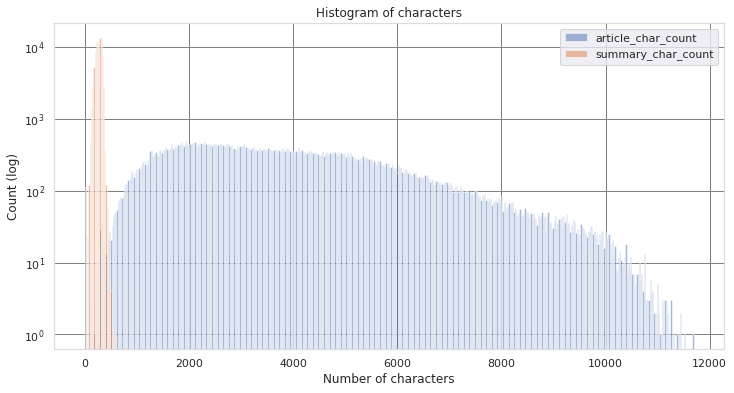

In [174]:
plot_distributions(corpus, 
                   ['article_char_count', 'summary_char_count'],
                   ['article', 'summary'],
                    'Histogram of characters',
                    'Number of characters',
                    'Count (log)',
                   bins = 500)
                   

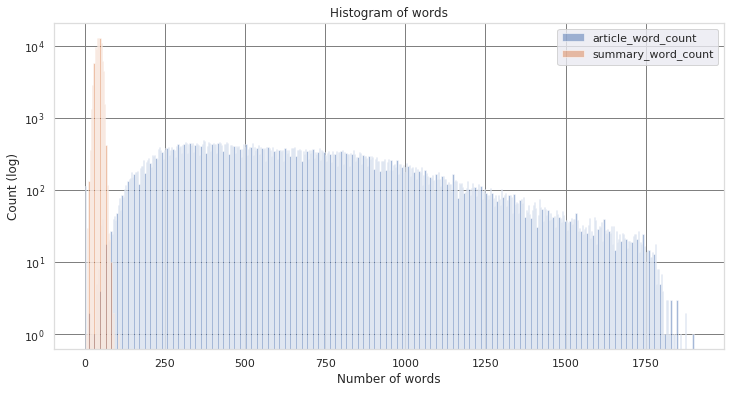

In [175]:
plot_distributions(corpus, 
                   ['article_word_count', 'summary_word_count'],
                   ['article', 'summary'],
                    'Histogram of words',
                    'Number of words',
                    'Count (log)',
                   bins = 500)

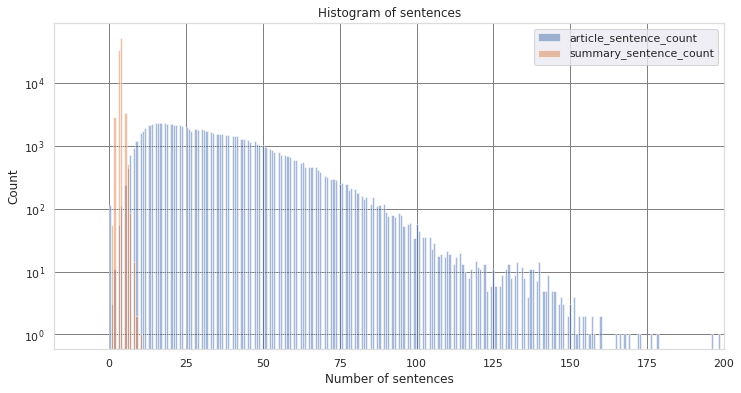

In [182]:
plot_distributions(corpus, 
                   ['article_sentence_count', 'summary_sentence_count'],
                   ['article', 'summary'],
                    'Histogram of sentences',
                    'Number of sentences',
                    'Count',
                   bins = 500,
                   logy = True,
                    xmax = 200)
##plt.savefig('hist_sentences.png', transparent=True)

## 6. Tokenization of whole corpus

In [35]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/lopasso/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /home/lopasso/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /home/lopasso/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/lopasso/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [36]:
def create_dictionaries_tables(text_list):
    
    freq_words = dict()
    freq_stems = dict()
    freq_lemmas = dict()
   
    for text in text_list:
    # Removing stop words
        stop_words = set(stopwords.words('english'))
        words = tokens_without_punctuation(text)
    
    # Reducing words to their root form with stems and lemmas
        stem = PorterStemmer()
        lem = WordNetLemmatizer()
    
    # Creating dictionaries for the word, stem and lemma frequencies
        for word in words:
            # dictionary of words
            if word in stop_words:
                continue
            if word in freq_words:
                freq_words[word] += 1
            else:
                freq_words[word] = 1
            # dictionary of stems        
            stemed = stem.stem(word)
            if stemed in stop_words:
                continue
            if stemed in freq_stems:
                freq_stems[stemed] += 1
            else:
                freq_stems[stemed] = 1
            # dictionary of lemmas        
            lemma = lem.lemmatize(word)
            if lemma in stop_words:
                continue
            if lemma in freq_lemmas:
                freq_lemmas[lemma] += 1
            else:
                freq_lemmas[lemma] = 1
    
    return freq_words, freq_stems, freq_lemmas

In [ ]:
t0 = time.time()
dict_word, dict_stem, dict_lemma = create_dictionaries_tables(corpus['article'].tolist())
print()
print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))

In [43]:
print('The total number of tokens in the article corpus are:')
print('Words: {:,}'.format(len(dict_word)))
print('Stems: {:,}'.format(len(dict_stem)))
print('Lemmas: {:,}'.format(len(dict_lemma)))

The total number of tokens in the article corpus are:
Words: 406,072
Stems: 304,580
Lemmas: 392,949


In [111]:
import pickle

def save_dict(dictionary, name = 'file.pkl'):
    f = open(name, 'wb')
    pickle.dump(dictionary,f)
    f.close()
    
def load_dict(name):
    with open(name, 'rb') as f:
        dictionary = pickle.load(f)
    return dictionary

In [112]:
#save_dict(dict_word, name = DATA_CLEANED_DIRECTORY + 'dict_word_article.pkl')
#save_dict(dict_stem, name = DATA_CLEANED_DIRECTORY +'dict_stem_article.pkl')
#save_dict(dict_lemma, name = DATA_CLEANED_DIRECTORY +'dict_lemma_article.pkl')

In [114]:
dict_word = load_dict(DATA_CLEANED_DIRECTORY + 'dict_word_article.pkl')
dict_stem = load_dict(DATA_CLEANED_DIRECTORY + 'dict_stem_article.pkl')
dict_lemma = load_dict(DATA_CLEANED_DIRECTORY + 'dict_lemma_article.pkl')

In [137]:
t0 = time.time()
dict_word_s, dict_stem_s, dict_lemma_s = create_dictionaries_tables(corpus['summary'].tolist())
print()
print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))


Total time to execute: 8.24 minutes


In [138]:
print('The total number of tokens in the summary corpus are:')
print('Words: {:,}'.format(len(dict_word_s)))
print('Stems: {:,}'.format(len(dict_stem_s)))
print('Lemma: {:,}'.format(len(dict_lemma_s)))

The total number of tokens in the summary corpus are:
Words: 106,215
Stems: 71,740
Lemma: 100,014


In [139]:
#save_dict(dict_word_s, name = DATA_CLEANED_DIRECTORY + 'dict_word_summary.pkl')
#save_dict(dict_stem_s, name = DATA_DIRECTORY +'dict_stem_summary.pkl')
#save_dict(dict_lemma_s, name = DATA_DIRECTORY + 'dict_lemma_summary.pkl')

In [115]:
dict_word_s = load_dict(DATA_CLEANED_DIRECTORY + 'dict_word_summary.pkl')
dict_stem_s = load_dict(DATA_CLEANED_DIRECTORY + 'dict_stem_summary.pkl')
dict_lemma_s = load_dict(DATA_CLEANED_DIRECTORY + 'dict_lemma_summary.pkl')

In [119]:
def extract_top_n_from_dict(dict_input, n = 20):
    l = []
    for i, (word, count) in enumerate(sorted(dict_input.items(), reverse=True, key=lambda x: x[1])):  
        if i >= n and count<l[-1][1]:
            break
        l.append((word, count))
    return l

In [185]:
def make_two_bar_charts(list1, list2, title = 'bar chart'):
    fig = plt.figure(figsize=(12,6))
    ax1 = fig.add_subplot(121)
    ax2 = fig.add_subplot(122)
    #fig, (ax1, ax2) = plt.subplots(1, 2)
    #fig = fig(figsize((12,6)))
    ax1.barh(y = [x[0] for x in list1], width = [x[1]/1000 for x in list1], color = 'blue')
    ax2.barh(y = [x[0] for x in list2], width = [x[1]/1000 for x in list2], color = 'red')
    fig.suptitle(title)
    ax1.set_title('Articles')
    ax2.set_title('Summaries')

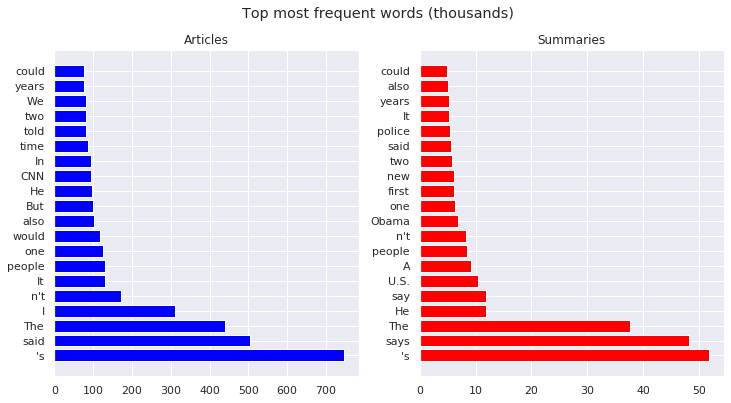

In [186]:
l = extract_top_n_from_dict(dict_word, 20)
l_s = extract_top_n_from_dict(dict_word_s, 20)
make_two_bar_charts(l, l_s, 'Top most frequent words (thousands)')

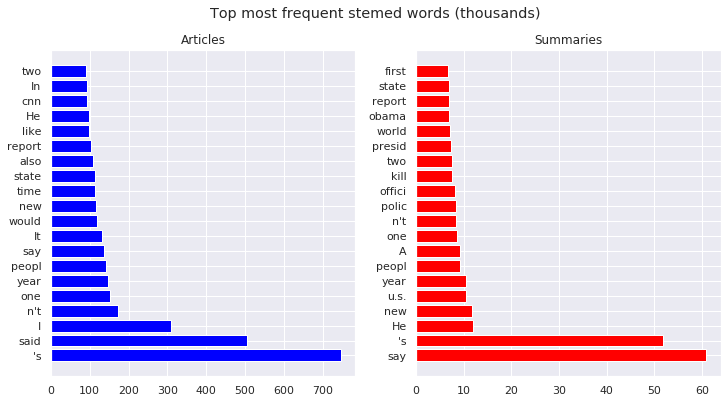

In [187]:
l = extract_top_n_from_dict(dict_stem, 20)
l_s = extract_top_n_from_dict(dict_stem_s, 20)
make_two_bar_charts(l, l_s, 'Top most frequent stemed words (thousands)')

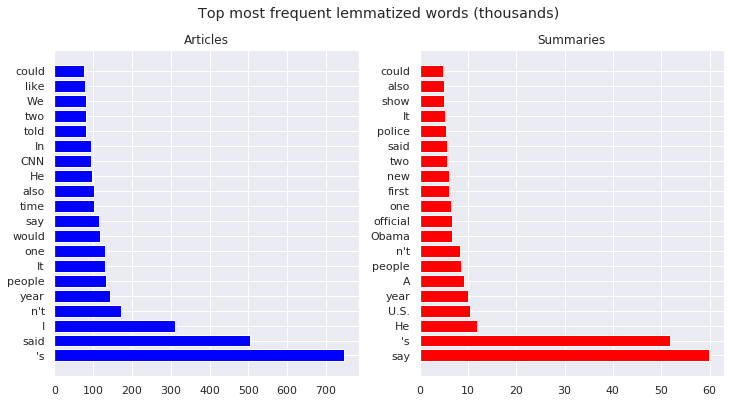

In [188]:
l = extract_top_n_from_dict(dict_lemma, 20)
l_s = extract_top_n_from_dict(dict_lemma_s, 20)
make_two_bar_charts(l, l_s, 'Top most frequent lemmatized words (thousands)')

## 7. Part-of-Speech (POS)

In [51]:
tokens = dict_word.keys()
tokens_s = dict_word_s.keys()

In [52]:
t0 = time.time()
pos_tags_token = pos_tag(tokens)
pos_tags_token_s = pos_tag(tokens_s)
dict_pos_tags = dict()
dict_pos_tags_s = dict()
for i in pos_tags_token:
    counter = dict_word[i[0]]
    if i[1] in dict_pos_tags:
        dict_pos_tags[i[1]] += counter
    else:
        dict_pos_tags[i[1]] = counter
        
for i in pos_tags_token_s:
    counter = dict_word_s[i[0]]
    if i[1] in dict_pos_tags_s:
        dict_pos_tags_s[i[1]] += counter
    else:
        dict_pos_tags_s[i[1]] = counter 
        
print()
print('Total time to execute: {:.2f} minutes'.format((time.time() - t0)/60))


Total time to execute: 1.95 minutes


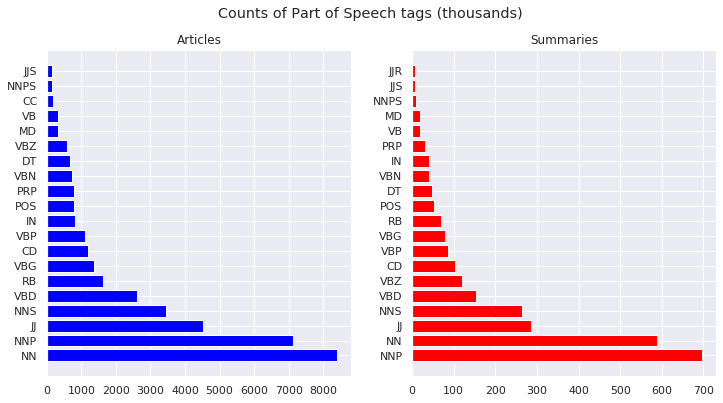

In [190]:
l = extract_top_n_from_dict(dict_pos_tags, 20)
l_s = extract_top_n_from_dict(dict_pos_tags_s, 20)
make_two_bar_charts(l, l_s, 'Counts of Part of Speech tags (thousands)')

In [56]:
#save_dict(dict_pos_tags, name = DATA_DIRECTORY + 'POS_article.pkl')
#save_dict(dict_pos_tags_s, name = DATA_DIRECTORY + 'POS_summary.pkl')

In [144]:
dict_pos_tags = load_dict(DATA_CLEANED_DIRECTORY + 'POS_article.pkl')
dict_pos_tags_s = load_dict(DATA_CLEANED_DIRECTORY + 'POS_summary.pkl')

## 8. Look for anomalies in the corpus (to do)